In [1]:
import os
import sys
import glob
import re

import random 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import decoupler

import scanpy as sc
#from kneed import KneeLocator 

import pandas as pd

import session_info
import warnings
from pyprojroot.here import here

sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import get_HVG

#plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

# Setting some parameters
warnings.filterwarnings("ignore")

overwriteData = True
overwriteFigures = True

# Set random seed
random_seed = 25

# Percentage of patient, stratifie by disease and gender, to keep out from the embedded space
# Please notice that, at least one patient for each disease, will be selected
p_perc = 0.1

# thresholds to select Differentially Expressed Genes between healthy vs. each disease
FCthr = 1.5
FDRthr = 0.01

### Load single-cell data

In [3]:
# Load the h5ad file
adata = sc.read_h5ad(here("02_fromCellLineages_to_CellTypes/INFLAMMATION_main_annotated_LowQFilt.h5ad"))
adata

AnnData object with n_obs × n_vars = 4435922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

**Removing genes with less then 1 count in each dataset or uniformative**

Loading gene list computed in step 02.

We already excluded 'unwanted' genes (i.e., mitochondrial, ribosomal, TCR, BCR, IGH, HLA, Platelet related) from the list

In [4]:
genesToKeep = pd.read_pickle(here("03_downstream_analysis/02_gene_universe_definition/results/02_preselectedGenes.pkl"))
genesToKeep

,hgnc_id,symbol
ensembl_gene_id,,
ENSG00000000003,HGNC:11858,TSPAN6
ENSG00000000419,HGNC:3005,DPM1
ENSG00000000457,HGNC:19285,SCYL3
ENSG00000000460,HGNC:25565,FIRRM
ENSG00000000938,HGNC:3697,FGR
...,...,...
ENSG00000278845,HGNC:16651,MRPL45
ENSG00000280670,HGNC:27003,CCDC163
ENSG00000280789,HGNC:28707,PAGR1


**keeping genes that could be usefull to define spurious cell types (i.e., MHC and PLaTelet)**

In [5]:
# Some of those genes will be included anyway because are part of curated gene sets.
MHC_gene_idx = adata.var["symbol"].str.contains("^HLA-")
print(f"{np.sum(MHC_gene_idx)} MHC genes")

PLT_gene_idx = adata.var["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])
print(f"{np.sum(PLT_gene_idx)} PLT genes")

21 MHC genes
5 PLT genes


In [9]:
adata_filt = adata[:,(adata.var.index.isin(genesToKeep.index) | MHC_gene_idx | PLT_gene_idx)]
adata_filt

View of AnnData object with n_obs × n_vars = 4435922 × 14127
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [10]:
genes = adata_filt.var
# Retrieve MT and RB genes present in the dataset
MT_gene_idx = genes["symbol"].str.startswith("MT-")
print(f"{np.sum(MT_gene_idx)} mitochondrial genes")

RB_gene_idx = genes["symbol"].str.startswith(("RPS", "RPL"))
print(f"{np.sum(RB_gene_idx)} ribosomal genes")

# Retrieve TCR and BCR present in the dataset
TCR_gene_idx = genes["symbol"].str.contains("^TRA(J|V)|^TRB(J|V|D)")
print(f"{np.sum(TCR_gene_idx)} TCR genes")

BCR_gene_idx = genes["symbol"].str.contains("^IGH(J|V)") # ("^IGH(J|V|D)|IGK(J|V)|^IGL(J|V)")
print(f"{np.sum(BCR_gene_idx)} BCR genes")

HB_gene_idx = genes["symbol"].str.contains("^HB[^(P)]")
print(f"{np.sum(HB_gene_idx)} HB genes")

# Some of those genes will be included anyway because are part of curated gene sets.
MHC_gene_idx = genes["symbol"].str.contains("^HLA-")
print(f"{np.sum(MHC_gene_idx)} MHC genes")

PLT_gene_idx = genes["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])
print(f"{np.sum(PLT_gene_idx)} PLT genes")

0 mitochondrial genes
0 ribosomal genes
0 TCR genes
0 TCR genes
0 HB genes
21 MHC genes
5 PLT genes


### Normalizing and log-scaling

In [11]:
# Keeping 'raw' counts
adata_filt.layers["counts"] = adata_filt.X.copy()

# Normalization, replace adata.X and storing
sc.pp.normalize_total(adata_filt, target_sum=1e4)
sc.pp.log1p(adata_filt)

## Defining High Variable Gene

In [12]:
def get_HVG(adata, groupby = None, batch_key = None, n_top_genes = None, flavor = 'seurat', min_number_cells = 5, min_disp=0.3, max_disp = 'inf', min_mean=0.01, max_mean=4, n_bins=20):
    import anndata as ad
    import pandas as pd
    import numpy as np
    import scanpy as sc
    from tqdm import tqdm

    if max_disp == 'inf':
        max_disp = float('inf')
        
    HVGdf = pd.DataFrame()
    if groupby is not None:
        listGroups = adata.obs[groupby].unique()

        for g in tqdm(listGroups):
            #print(g)
            adata_g = adata[adata.obs[groupby]==g]
            if adata_g.shape[0] <= min_number_cells:
                print('WARNING: The group {} includes only {} cells. Not considered'.format(g, adata_g.shape[0]))
                continue
            HVGdf_i = sc.pp.highly_variable_genes(adata=adata_g, 
                                    batch_key=batch_key, 
                                    flavor=flavor, 
                                    n_top_genes = n_top_genes,
                                    min_disp=min_disp, 
                                    max_disp=max_disp, 
                                    min_mean=min_mean, 
                                    max_mean=max_mean, 
                                    n_bins=n_bins, inplace=False)

            HVGdf_i = HVGdf_i.add_suffix('_{}'.format(g))
            if batch_key is None:
                HVGdf_i['gene_name'] = adata_g.var_names
                HVGdf_i.set_index('gene_name', inplace=True, drop=True)
                HVGdf_i.index.name = None
            HVGdf = HVGdf.merge(HVGdf_i, how='right', left_index=True, right_index=True)
            

    else:
        HVGdf = sc.pp.highly_variable_genes(adata=adata, 
                                            batch_key=batch_key, 
                                            flavor=flavor, 
                                            n_top_genes = n_top_genes,
                                            min_disp=min_disp, 
                                            max_disp=max_disp, 
                                            min_mean=min_mean, 
                                            max_mean=max_mean, 
                                            n_bins=n_bins,
                                            inplace=False)
        HVGdf['gene_name'] = adata.var_names
        HVGdf.set_index('gene_name', inplace=True, drop=True)
        HVGdf.index.name = None
    
    return(HVGdf)

In [13]:
HVGdf = get_HVG(adata_filt, 
                groupby='studyID', 
                n_top_genes=None, 
                batch_key='libraryID', 
                flavor='seurat', 
                min_disp=0.3, 
                max_disp = 'inf', 
                min_mean=0.01, max_mean=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [03:54<00:00, 14.68s/it]


In [14]:
# Considering only genes selected as HV in at least 1 study
columns_to_keep = [f'highly_variable_{study_id}' for study_id in adata_filt.obs['studyID'].unique() if f'highly_variable_{study_id}' in HVGdf.columns]

HVG_sel_DF = HVGdf.loc[:, columns_to_keep]
HVG_sel_DF = HVG_sel_DF[HVG_sel_DF.sum(axis=1) > 0]
HVG_sel_DF.columns = HVG_sel_DF.columns.str.removeprefix("highly_variable_")
HVG_sel_DF.head()

,SCGT00,SCGT01,SCGT02,SCGT03,SCGT04,SCGT05,Reyes2020,Cillo2020,Zhang2023,Schafflick2020,Liu2021,Terekhova2023,Perez2022,Wang2020,COMBAT2022,Ren2021
ensembl_gene_id,,,,,,,,,,,,,,,,
ENSG00000000003,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
ENSG00000000457,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False
ENSG00000000460,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
ENSG00000000938,False,False,False,True,False,True,False,True,True,False,True,True,False,False,False,False
ENSG00000000971,False,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True


In [15]:
HVGunion = list()
for c in HVG_sel_DF.columns:
    HVGunion += HVG_sel_DF.index[HVG_sel_DF[c]].tolist()

In [16]:
HVGperStudyCount = pd.DataFrame(index = HVG_sel_DF.index)
HVGperStudyCount['n_studies'] = HVG_sel_DF.sum(axis = 1)

In [17]:
HVGperStudyCount

,n_studies
ensembl_gene_id,
ENSG00000000003,2
ENSG00000000457,4
ENSG00000000460,2
ENSG00000000938,6
ENSG00000000971,12
...,...
ENSG00000278677,5
ENSG00000278705,9
ENSG00000278828,15


In [18]:
CumStud_n = pd.DataFrame(HVGperStudyCount['n_studies'].value_counts())
CumStud_n.sort_index(ascending=False, inplace=True)
CumStud_n['cs_studies'] = CumStud_n['count'].cumsum().tolist()
CumStud_n

,count,cs_studies
n_studies,,
16,240,240
15,155,395
14,139,534
13,140,674
12,139,813
11,202,1015
10,235,1250
9,276,1526
8,338,1864


In [19]:
nStudyThr = 5
HVG_number = 3000

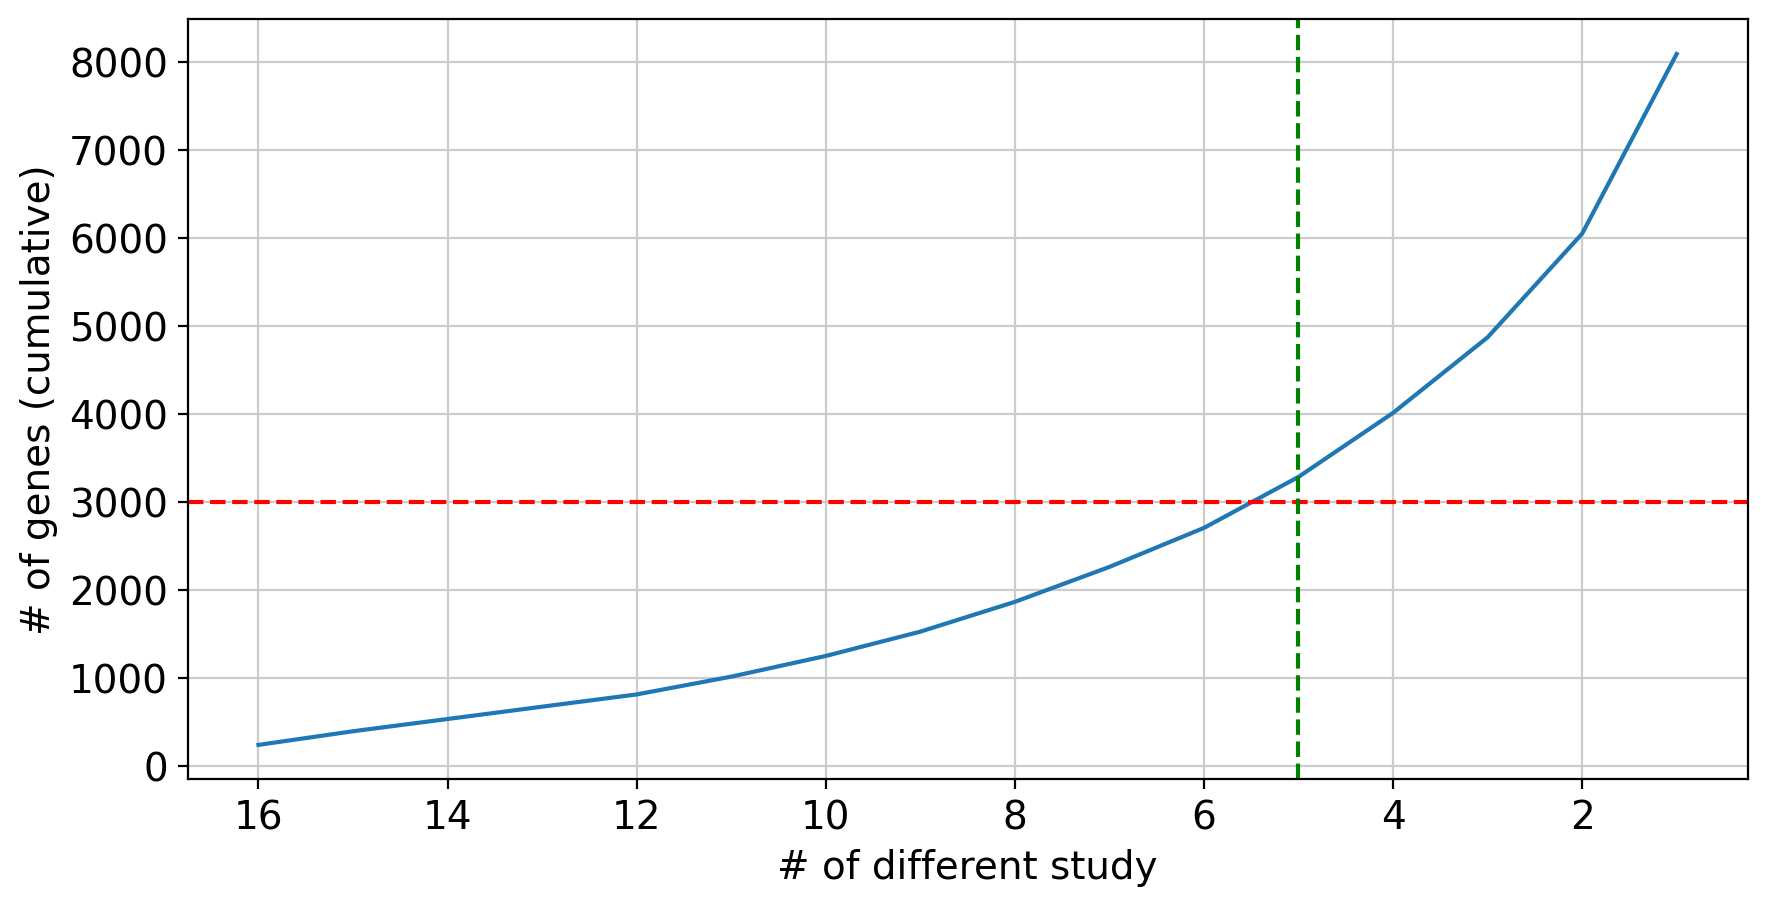

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 5))
CumStud_n.cs_studies.plot(ax=ax)

plt.axhline(y = HVG_number, color = 'r', linestyle = '--')
plt.axvline(x = nStudyThr, color = 'g', linestyle = '--')
plt.xlabel('# of different study')
plt.ylabel('# of genes (cumulative)')
plt.gca().invert_xaxis()

if overwriteFigures:
    plt.savefig(here('03_downstream_analysis/02_gene_universe_definition/results/04_HVG_selection_threshold.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()

In [21]:
HVG_selected = HVGperStudyCount[HVGperStudyCount['n_studies'] >= nStudyThr].index.tolist()
len(HVG_selected)

3283

## Curated Human immune-specific gene sets

In the final embedded space, generated with scVI, we are also interested in investigating the distribution of a list of immune-related genes. Such list was defined manually by immunologist expert. We will add them to the HVG list selected above

In [22]:
immunoGeneDF = pd.read_pickle(here('03_downstream_analysis/05_SPECTRA/results/SPECTRA_GeneSet_ensg_v2.pickle'))
immunoGeneDF
#immunoGenes = [g for g in immunoGeneDF.values.flatten() if ((str(g) != 'nan') and (str(g) in adata.var_names))]

{'global': {'global_all_IL6-JAK-STAT3_signaling': ['ENSG00000141506',
   'ENSG00000096996',
   'ENSG00000243646',
   'ENSG00000164400',
   'ENSG00000004468',
   'ENSG00000163734',
   'ENSG00000134460',
   'ENSG00000077238',
   'ENSG00000163737',
   'ENSG00000105397',
   'ENSG00000227507',
   'ENSG00000026103',
   'ENSG00000205755',
   'ENSG00000184371',
   'ENSG00000115145',
   'ENSG00000142166',
   'ENSG00000027697',
   'ENSG00000139567',
   'ENSG00000131724',
   'ENSG00000056736',
   'ENSG00000196396',
   'ENSG00000143575',
   'ENSG00000170458',
   'ENSG00000105329',
   'ENSG00000168610',
   'ENSG00000159128',
   'ENSG00000198223',
   'ENSG00000134470',
   'ENSG00000184557',
   'ENSG00000100368',
   'ENSG00000259207',
   'ENSG00000115232',
   'ENSG00000169245',
   'ENSG00000111321',
   'ENSG00000213928',
   'ENSG00000170581',
   'ENSG00000067182',
   'ENSG00000124334',
   'ENSG00000163823',
   'ENSG00000232810',
   'ENSG00000006327',
   'ENSG00000137193',
   'ENSG00000108688',
   'EN

In [23]:
def extract_genes(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            yield from extract_genes(value)
        else:
            yield value

In [24]:
import itertools
curated_gene_list = list(set(itertools.chain(*extract_genes(immunoGeneDF))))

In [25]:
len(curated_gene_list)

734

## Differential expressed genes between healthy and each disease

In [26]:
DEGdf = pd.read_csv(here('03_downstream_analysis/02_gene_universe_definition/results/03_DEhealthyVSothers_allGene.csv'), sep='\t')
# DEGlist = DEGdf.genes.unique().tolist()
# len(DEGlist)

In [27]:
DEGlist = DEGdf.query('abs(logFC) > @FCthr and FDRfinal < @FDRthr').genes.unique().tolist()

In [28]:
print('Total number of genes selected (not unique) is {}'.format(len(HVG_selected)+len(DEGlist)+len(curated_gene_list)))

Total number of genes selected (not unique) is 10885


### Union of the three gene lists

In [29]:
selectedGenes = list(set(DEGlist + HVG_selected + curated_gene_list))

In [30]:
print('The final list includes {} selected unique genes'.format(len(selectedGenes)))

The final list includes 8253 selected unique genes


In [31]:
adata.var['highly_variable'] = False
adata.var.loc[selectedGenes,'highly_variable'] = True

adata_selGenes = adata[:, adata.var.highly_variable]
adata_selGenes

View of AnnData object with n_obs × n_vars = 4435922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'

In [53]:
del adata

In [32]:
selectedGeneDF = adata_selGenes.var[['hgnc_id','symbol','locus_group','HUGO_status']]#pd.DataFrame.from_dict({'gene':selectedGenes})
selectedGeneDF.head()

,hgnc_id,symbol,locus_group,HUGO_status
ensembl_gene_id,,,,
ENSG00000000003,HGNC:11858,TSPAN6,protein_coding,official
ENSG00000000457,HGNC:19285,SCYL3,protein_coding,official
ENSG00000000938,HGNC:3697,FGR,protein_coding,official
ENSG00000000971,HGNC:4883,CFH,protein_coding,official
ENSG00000001036,HGNC:4008,FUCA2,protein_coding,official


In [33]:
genes=selectedGeneDF

In [34]:
# Retrieve MT and RB genes present in the dataset
MT_gene_idx = genes["symbol"].str.startswith("MT-")
print(f"{np.sum(MT_gene_idx)} mitochondrial genes")

RB_gene_idx = genes["symbol"].str.startswith(("RPS", "RPL"))
print(f"{np.sum(RB_gene_idx)} ribosomal genes")

# Retrieve TCR and BCR present in the dataset
TCR_gene_idx = genes["symbol"].str.contains("^TRA(J|V)|^TRB(J|V|D)")
print(f"{np.sum(TCR_gene_idx)} TCR genes")

BCR_gene_idx = genes["symbol"].str.contains("^IGH(J|V)")
print(f"{np.sum(BCR_gene_idx)} TCR genes")

HB_gene_idx = genes["symbol"].str.contains("^HB[^(P)]")
print(f"{np.sum(HB_gene_idx)} HB genes")

# Some of those genes will be included anyway because are part of curated gene sets.
MHC_gene_idx = genes["symbol"].str.contains("^HLA-")
print(f"{np.sum(MHC_gene_idx)} MHC genes")

PLT_gene_idx = genes["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])
print(f"{np.sum(PLT_gene_idx)} PLT genes")

0 mitochondrial genes
0 ribosomal genes
0 TCR genes
0 TCR genes
1 HB genes
20 MHC genes
3 PLT genes


In [35]:
selectedGeneDF.to_csv(here("03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.csv"), sep=',')
selectedGeneDF.to_pickle(here("03_downstream_analysis/02_gene_universe_definition/results/04_selected_gene_list.pkl"), protocol=4)

## Save MAIN object after subsetting

**Cleaning object to keep only relevant fields for the next steps**

**There is a problem in restoring count matrix. Thus, I reload the object before normalization**

In [36]:
adata = sc.read_h5ad(here("02_fromCellLineages_to_CellTypes/INFLAMMATION_main_annotated_LowQFilt.h5ad"))
adata

AnnData object with n_obs × n_vars = 4435922 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [37]:
adata.var['highly_variable'] = False
adata.var.loc[selectedGenes,'highly_variable'] = True

adata_selGenes = adata[:, adata.var.highly_variable]
adata_selGenes

View of AnnData object with n_obs × n_vars = 4435922 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'

In [38]:
if overwriteData:
    adata_selGenes.write(here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse.h5ad"), compression="gzip")

**Cleaning object to keep only relevant cell-types for downstream analyses**

We want to remove spurious cells like RBC and Platelets only from the embedding used for downstream analyses aimed at characterizing the inflammation landscape from immune cells. However, we want to keep them in the final atlas embedding (used, for instance, in the patient classifier) because it should improve the projection of external data 

In [39]:
adata_selGenes.obs.Level1.unique().tolist()

['T_CD8_NonNaive',
 'T_CD4_Naive',
 'Mono',
 'T_CD4_NonNaive',
 'Platelets',
 'ILC',
 'B',
 'T_CD8_Naive',
 'DC',
 'Cycling_cells',
 'pDC',
 'RBC',
 'UTC',
 'Plasma',
 'Progenitors']

In [40]:
adata_selCT = adata_selGenes[~adata_selGenes.obs.Level1.isin(['RBC','Platelets'])].copy()
adata_selCT

View of AnnData object with n_obs × n_vars = 4279352 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable'

In [41]:
if overwriteData:
    adata_selCT.write(here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse_noRBCnPlatelets.h5ad"), compression="gzip")

**log1p-normalization**

i.e., scGen or Harmony starts from normalized data. To avoid normalize multiple times, we are generating and saving here the normalized object

In [ ]:
sc.pp.normalize_total(adata_selGenes, target_sum=1e4)
sc.pp.log1p(adata_selGenes)

In [ ]:
### SAVING THE NORMALIZED OBJECT
if overwriteData:
    adata_selGenes.write(here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse.log1p.h5ad"), compression="gzip")

In [3]:
sc.pp.normalize_total(adata_selCT, target_sum=1e4)
sc.pp.log1p(adata_selCT)

In [4]:
### SAVING THE NORMALIZED OBJECT
if overwriteData:
    adata_selCT.write(here("03_downstream_analysis/02_gene_universe_definition/results/04_MAIN_geneUniverse_noRBCnPlatelets.log1p.h5ad"), compression="gzip")

In [42]:
session_info.show()